# LSTM Regression
[Source](https://www.crosstab.io/articles/time-series-pytorch-lstm)

In [1]:
import pandas as pd

# Load data

In [3]:
data = pd.read_excel("data/4-combined_data_participant1_15min.xlsx",
                    index_col = "timestamp")
data

,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,...,pain,tremors,anxiety,rigidity,slowdown,slow_thoughts,impairment_hands,moodchange,muscle_spasm,wearing_off_post_meds
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-25 00:00:00,-1.000000,0,-1.0,-1,-1,-1,-1,-1,-1,-1.0,...,0,0,0,0,0,0,0,0,0,0
2021-11-25 00:15:00,-1.000000,0,-1.0,-1,-1,-1,-1,-1,-1,-1.0,...,0,0,0,0,0,0,0,0,0,0
2021-11-25 00:30:00,21.950000,0,-0.4,-1,-1,-1,-1,-1,-1,-1.0,...,0,0,0,0,0,0,0,0,0,0
2021-11-25 00:45:00,60.250000,0,12.4,-1,-1,-1,-1,-1,-1,-1.0,...,0,0,0,0,0,0,0,0,0,0
2021-11-25 01:00:00,10.600000,0,-1.0,-1,-1,-1,-1,-1,-1,-1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03 22:45:00,103.450000,126,27.4,55,227,84,0,311,311,1.0,...,0,0,0,0,0,0,0,0,0,0
2021-12-03 23:00:00,104.250000,384,-1.4,55,227,84,0,311,311,1.0,...,0,0,0,0,0,0,0,0,0,0
2021-12-03 23:15:00,97.233333,54,10.8,55,227,84,0,311,311,1.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
columns = [ 'timestamp', 
           'heart_rate', 'steps', 'stress_score',
           'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 
           'nonrem_percentage', 'sleep_efficiency']

# Include FonLog data
# columns = columns + ['time_from_last_drug_taken'] #, 'wo_duration']

target_column = 'wearing_off' # 'wearing_off' | 'wearing_off_post_meds'
columns.append(target_column)

# select only columns
data = data.loc[:, columns[1:]]

# Shift wearing-off forward

In [5]:
# 60: target forecast of 1 hour
# 15: current frequency
forecast_lead = 60
forecast_lead_rows = int( 60 / 15 )
target = f"{target_column}_lead{forecast_lead}"

data[target] = data[target_column].shift(-forecast_lead_rows)
data = data.iloc[:-forecast_lead_rows]

# Create hold-out test set

In [6]:
print(data.index.min())
print(data.index.max())

2021-11-25 00:00:00
2021-12-03 22:45:00


In [7]:
test_start = "2021-12-02"

data_train = data.loc[:test_start].copy()
data_test = data.loc[test_start:].copy()

print("Test set fraction:", len(data_test) / len(data))

Test set fraction: 0.2186046511627907


## Standardize data

In [8]:
target_mean = data_train[target].mean()
target_stdev = data_train[target].std()

for c in data_train.columns:
    mean = data_train[c].mean()
    stdev = data_train[c].std()

    data_train[c] = (data_train[c] - mean) / stdev
    data_test[c] = (data_test[c] - mean) / stdev


# Create dataset using PyTorch DataLoader

In [9]:
import torch
from torch.utils.data import Dataset

In [10]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [11]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

## Sample DataLoader

In [ ]:
i = 27
sequence_length = 4

train_dataset = SequenceDataset(data_train,
                                target=target,
                                features=columns[1:-1],
                                sequence_length=sequence_length
)
X, y = train_dataset[i]
print(X)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)


# Real Data Setup

In [12]:
torch.manual_seed(101)
features = columns[1:-1]

batch_size = 1
sequence_length = 4

train_dataset = SequenceDataset(
    data_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    data_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 4, 11])
Target shape: torch.Size([1])


# Model & Learning Algorithm

In [13]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [14]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_features=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()


Untrained test
--------
Test loss: 0.8885715191074192

Epoch 0
---------
Train loss: 1.0135352276437726
Test loss: 0.882290216915785

Epoch 1
---------
Train loss: 1.0027801948345558
Test loss: 0.8786319994783782

Epoch 2
---------
Train loss: 0.9941763427324698
Test loss: 0.8757377757314355

Epoch 3
---------
Train loss: 0.9869214185112014
Test loss: 0.873646645133007

Epoch 4
---------
Train loss: 0.9806488827395393
Test loss: 0.8720508626206441

Epoch 5
---------
Train loss: 0.9754094763172058
Test loss: 0.8711030484930157

Epoch 6
---------
Train loss: 0.9707104751165995
Test loss: 0.8705477546504203

Epoch 7
---------
Train loss: 0.9665924280537487
Test loss: 0.8704090620727932

Epoch 8
---------
Train loss: 0.9628400764055792
Test loss: 0.8706151309542041

Epoch 9
---------
Train loss: 0.9596887374812771
Test loss: 0.8710670104706065

Epoch 10
---------
Train loss: 0.9569370117778817
Test loss: 0.871803509965638

Epoch 11
---------
Train loss: 0.9543094329559002
Test loss: 0.8726

In [16]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
data_train[ystar_col] = predict(train_eval_loader, model).numpy()
data_test[ystar_col] = predict(test_loader, model).numpy()

data_out = pd.concat((data_train, data_test))[[target, ystar_col]]

for c in data_out.columns:
    data_out[c] = data_out[c] * target_stdev + target_mean

print(data_out)



                     wearing_off_lead60  Model forecast
timestamp                                              
2021-11-25 00:00:00                 0.0        0.157579
2021-11-25 00:15:00                 0.0        0.157579
2021-11-25 00:30:00                 0.0        0.156813
2021-11-25 00:45:00                 0.0        0.158239
2021-11-25 01:00:00                 0.0        0.159448
...                                 ...             ...
2021-12-03 21:45:00                 0.0        0.013999
2021-12-03 22:00:00                 0.0        0.013433
2021-12-03 22:15:00                 0.0        0.012529
2021-12-03 22:30:00                 0.0        0.012313
2021-12-03 22:45:00                 0.0        0.018840

[956 rows x 2 columns]


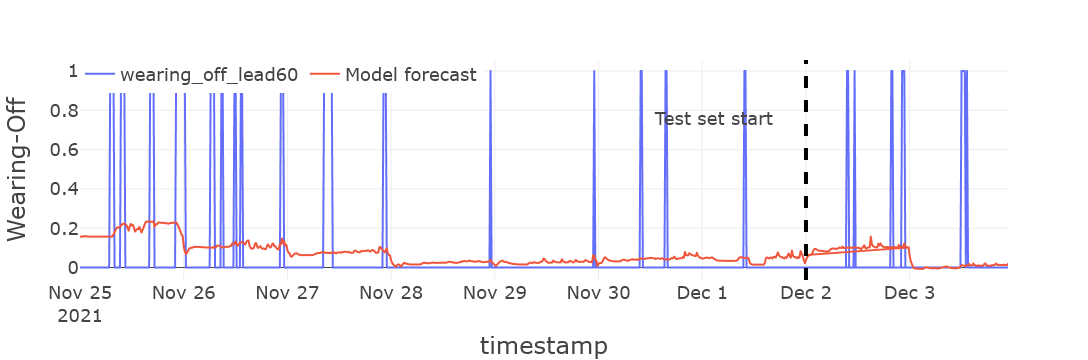

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(data_out, labels=dict(created_at="Date", value="Wearing-Off"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()
